In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit

In [3]:
# CORPUS_DIR = "convokit/thread_generator/fake-corpus-trajectory"
CORPUS_DIR = "convokit/thread_generator/annotated-fake-trajectory"

In [4]:
from convokit import TensorDecomposer, HyperConvo, Corpus

In [5]:
corpus = Corpus(filename=CORPUS_DIR)

In [6]:
hyperconv_range = range(2, 20+1)

In [7]:
# hyperconv_range = range(2, 20+1)
# def multi_hyperconv_transform(corpus, hyperconv_range):
#     hc_transformers = [HyperConvo(prefix_len=i, feat_name="hyperconvo-{}".format(i)) for i in hyperconv_range]
#     for idx, hc in enumerate(list(reversed(hc_transformers))):
#         print(hyperconv_range[-1]-idx)
#         hc.transform(corpus)

In [8]:
# multi_hyperconv_transform(corpus, hyperconv_range)

In [9]:
# corpus.dump("annotated-fake-trajectory", base_path="./convokit/thread_generator/")

In [10]:
import numpy as np
def _min_max_scale(mat):
    max_ = np.max(mat)
    min_ = np.min(mat)
    return (mat - min_) / (max_ - min_)

def minmax_normalize(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[2]):
        tensor[:, :, i] = _min_max_scale(tensor[:, :, i])
    return tensor

In [35]:
hyperconv_range = range(2, 20+1)
td = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in hyperconv_range],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      rank=3
                     )

In [36]:
td.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


Directory already exists. Exiting summarize()


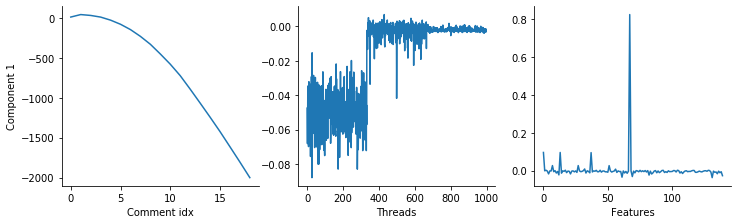

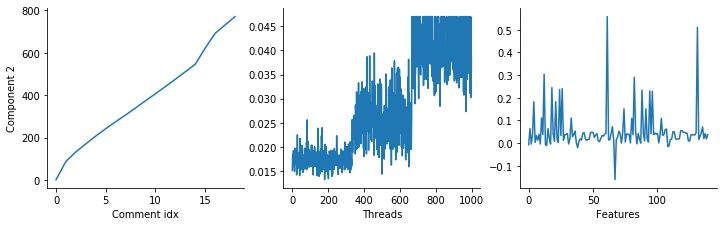

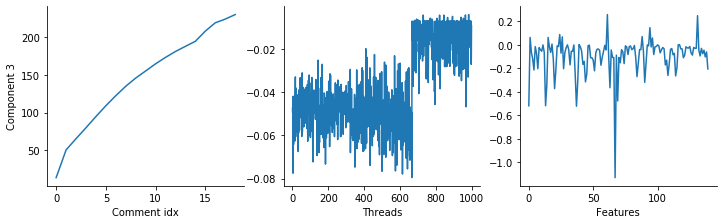

In [13]:
td.summarize(corpus, axis_names=["Comment idx", "Threads", "Features"], 
             output_dir='convokit/tensor_decomposer/reports/25May_normal', 
             report_title="25 May (normal)")

In [14]:
score = td.purity(n_clusters=3)
print(score)

0.963963963963964


## Standard (from 3)

In [15]:
td_3 = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(3, 20+1)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      rank=3
                     )

In [16]:
td_3.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


In [17]:
td_3.tensor.shape

(18, 999, 140)

In [18]:
score = td_3.purity(n_clusters=3)
print(score)

0.963963963963964


## Min-max normalized (across threads)

### From 2

In [19]:
td_min_max = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(2, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=minmax_normalize,
                      rank=3
                     )

In [20]:
td_min_max.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


Directory already exists. Exiting summarize()


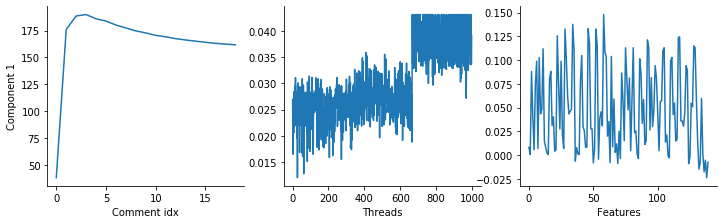

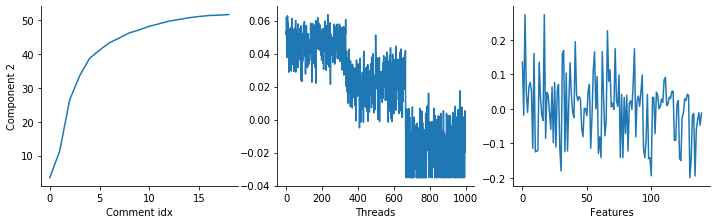

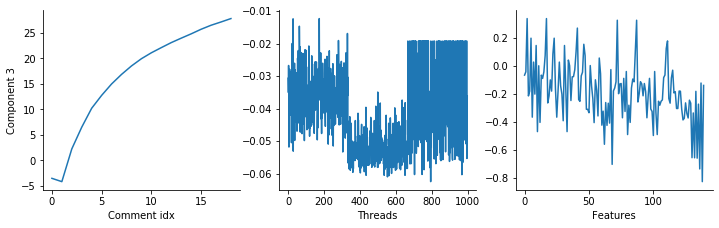

In [21]:
td_min_max.summarize(corpus, axis_names=["Comment idx", "Threads", "Features"], 
             output_dir='convokit/tensor_decomposer/reports/25May_minmax', 
             report_title="25 May (min_max)")

In [22]:
score = td_min_max.purity(n_clusters=3)
print(score)

0.8488488488488488


### From 3

In [37]:
td_min_max = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(3, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=minmax_normalize,
                      rank=3
                     )
td_min_max.fit(corpus)
td_min_max.purity(n_clusters=3)

Constructing tensor...Done.
Decomposing tensor...Done.


0.8778778778778779

## Standard-scaled (across threads)

In [24]:
from sklearn.preprocessing import StandardScaler
def standard_scale(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[2]):
        tensor[:, :, i] = StandardScaler().fit_transform(tensor[:, :, i])
    return tensor

### From 2

In [38]:
td_std_scale = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in hyperconv_range],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=standard_scale,
                      rank=3
                     )

In [39]:
td_std_scale.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


Directory already exists. Exiting summarize()


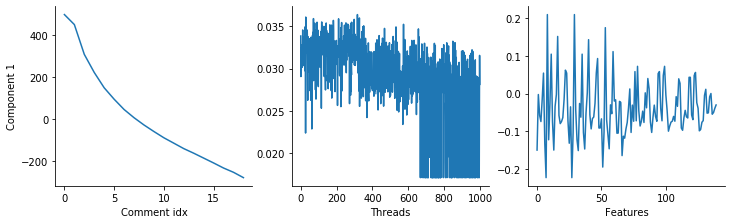

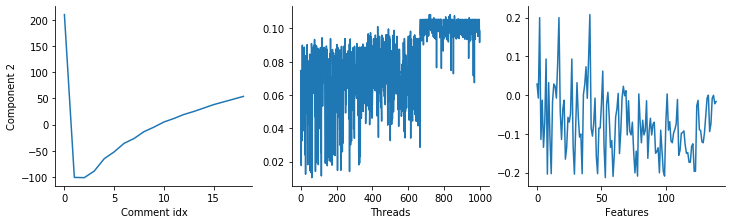

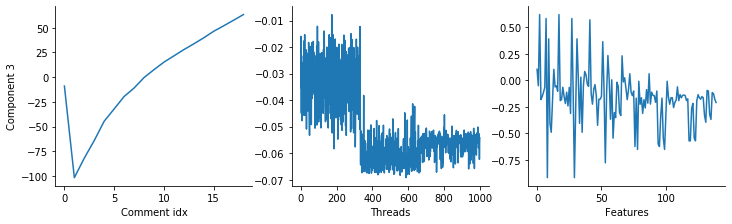

In [27]:
td_std_scale.summarize(corpus, axis_names=["Comment idx", "Threads", "Features"], 
             output_dir='convokit/tensor_decomposer/reports/25May_std_scl', 
             report_title="25 May (std scale)")

In [40]:
score = td_std_scale.purity(n_clusters=3)
print(score)

0.7427427427427428


### From 3

In [42]:
td_std_scale = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(3, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=standard_scale,
                      rank=3
                     )
td_std_scale.fit(corpus)
td_std_scale.purity(n_clusters=3)

Constructing tensor...Done.
Decomposing tensor...Done.


0.5095095095095095

## Min-max scaled (within thread)

In [29]:
from sklearn.preprocessing import MinMaxScaler

In [30]:
def _min_max_within(mat):
    mms = MinMaxScaler()
    for i in range(mat.shape[1]):
        min_ = np.min(mat[:, i])
        max_ = np.max(mat[:, i])
        if max_ - min_ == 0:
            mat[:, i] = 0
        else:
            mat[:, i] = (mat[:, i] - min_)/ (max_ - min_)
    return mat

def minmax_within(tensor):
    tensor = tensor.copy()
    for i in range(tensor.shape[1]):
        tensor[:, i, :] = _min_max_within(tensor[:, i, :])
    return tensor

## From 2

In [45]:
td_min_max_within = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in hyperconv_range],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=minmax_within,
                      rank=3
                     )

In [46]:
td_min_max_within.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


Directory already exists. Exiting summarize()


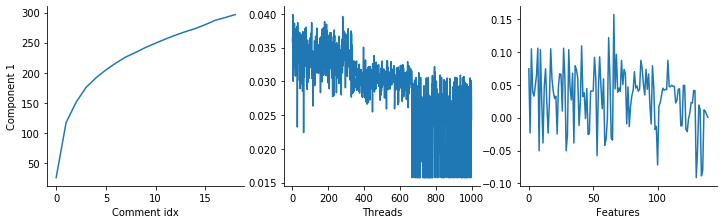

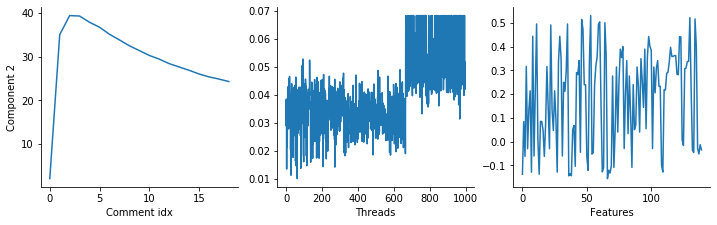

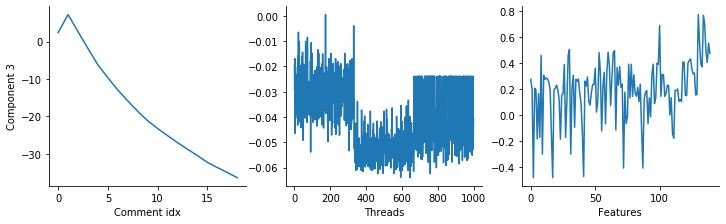

In [33]:
td_min_max_within.summarize(corpus, axis_names=["Comment idx", "Threads", "Features"], 
             output_dir='convokit/tensor_decomposer/reports/25May_minmax_within', 
             report_title="25 May (min max within)")

In [47]:
score = td_min_max_within.purity(n_clusters=3)
print(score)

0.7617617617617618


### From 3

In [48]:
td_min_max_within = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(3, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      normalize_func=minmax_within,
                      rank=3
                     )

In [49]:
td_min_max_within.fit(corpus)
td_min_max_within.purity(n_clusters=3)

Constructing tensor...Done.
Decomposing tensor...Done.


0.6346346346346347